# Random Forest - TF-IDF

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import math
from collections import OrderedDict

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
def make_x(REVtrain, REVtest, vectorizer=None, min_df = 1, max_df = 1.0):
    """Create the matrix of features """
    if vectorizer is None:
        print('The value of vectorizer is None ... using CountVectorizer')
    else:
        print('The value of vectorizer is NOT None ... using the provided vectorizer')
    #
    if vectorizer is None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words = sw, 
                                     min_df = min_df, max_df = max_df)
   
    Xtrain = vectorizer.fit_transform(REVtrain)
    Xtrain = Xtrain.tocsc() 
    
    Xtest = vectorizer.transform(REVtest)
    Xtest = Xtest.tocsc()
    
    return Xtrain, Xtest, vectorizer 


def roc_auc(fit, Xtest, ytest):
    yprobs = fit.predict_proba(Xtest)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,  yprobs)
    roc_auc = auc(fpr, tpr)
    print('AUC: ', roc_auc)

def plot_featimportances(forest, Xtrain, vectorizer, figname=None):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    col_names = []

    # Print the feature ranking
    print("Feature ranking:")
    feat_names = vectorizer.get_feature_names()
    
    for f in range(Xtrain.shape[1]):
        idx = indices[f]
        feat_name = feat_names[idx]
        col_names.append(feat_name)
    
    for i in range(50):
        col_name = col_names[i]
        print("%d. %s (%f)" % (i + 1, col_name, importances[indices[i]]))
        
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))

    plt.title("Feature importances")
    plt.bar(range(50), importances[indices[:50]],
           color="r", yerr=std[indices[f]], align="center")
    plt.xticks(range(50), col_names[:50], rotation='vertical')
    plt.xlim([-1, 50])
        
    if figname != None:
         plt.savefig(figname, dpi=300)
            
    return indices

In [3]:
def plot_oob_errors(Xtrain, ytrain, figname = None):
    RANDOM_STATE = 123

    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 25
    max_estimators = 75

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(Xtrain, ytrain)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    
    if figname != None:
         plt.savefig(figname, dpi=300)

In [4]:
 def report(fitted):   
    ypred = fitted.predict(Xtest)

    print("[Test Classification Report:]")
    print(classification_report(ytest, ypred))
    print('Test Accuracy: ', accuracy_score(ypred, ytest))

    yprobs = fitted.predict_proba(Xtest)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,  yprobs)
    roc_auc = auc(fpr, tpr)
    print('')
    print('AUC: ', roc_auc)
    print('')
    print('Log loss: ', log_loss(ytest, yprobs))
    
    return ypred, yprobs

In [5]:
infile = open('../SavedFiles/fastFood_eng_binary.pkl', 'rb')
fastFood = pickle.load(infile)
infile.close

<function BufferedReader.close>

In [6]:
RANDOM_STATE = 123

In [7]:
sw = ['a', 'an', 'the', 'and']
sw = sw + ['.', ',', '...', '\'\'', '\"', '``', '¡',  '{','|','||','}', '(', ')', 
           '\'','[',']', ';', ':', '-', '_','—', '\\','/', '*', '~', '?', '!']

In [8]:
tfidf = TfidfVectorizer(strip_accents = 'ascii', stop_words = sw, ngram_range = (1,2), min_df = 35, max_df = 45000)

In [9]:
REVtrain, REVtest, ytrain, ytest = train_test_split(fastFood.text_tok, fastFood.pos, random_state=123)

In [10]:
Xtrain, Xtest, vectorizer = make_x(REVtrain, REVtest, vectorizer = tfidf)

The value of vectorizer is NOT None ... using the provided vectorizer


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

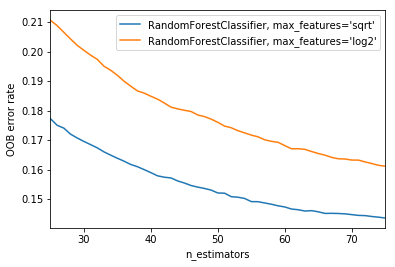

In [11]:
plot_oob_errors(Xtrain, ytrain, figname = 'OOB_tfidf.png')

In [15]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt',random_state=123)
fitted = rf.fit(Xtrain,ytrain)

ypred, yprobs = report(fitted)

#roc_auc(rf, Xtest, ytest)

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     27281
           1       0.88      0.88      0.88     27635

   micro avg       0.88      0.88      0.88     54916
   macro avg       0.88      0.88      0.88     54916
weighted avg       0.88      0.88      0.88     54916

Test Accuracy:  0.8772124699541117

AUC:  0.9471054409798692

Log loss:  0.3690271399111308


In [16]:
confusion_matrix(ytest, ypred)

array([[23904,  3377],
       [ 3366, 24269]])

Feature ranking:
1. great (0.016056)
2. delicious (0.009609)
3. friendly (0.008460)
4. best (0.008028)
5. love (0.007730)
6. amazing (0.007045)
7. worst (0.006773)
8. fresh (0.005539)
9. no (0.005477)
10. awesome (0.004890)
11. rude (0.004790)
12. horrible (0.004176)
13. always (0.004146)
14. excellent (0.003418)
15. slow (0.003384)
16. definitely (0.003291)
17. minutes (0.003229)
18. terrible (0.003220)
19. favorite (0.003028)
20. asked (0.002999)
21. nice (0.002971)
22. bad (0.002774)
23. fast (0.002720)
24. perfect (0.002660)
25. order (0.002633)
26. cold (0.002606)
27. ok (0.002602)
28. clean (0.002537)
29. ordered (0.002281)
30. didn (0.002231)
31. said (0.002209)
32. tasty (0.002127)
33. drive (0.002124)
34. don (0.002105)
35. dirty (0.002100)
36. then (0.002062)
37. told (0.002037)
38. just (0.001981)
39. very (0.001980)
40. my order (0.001899)
41. nothing (0.001886)
42. me (0.001840)
43. disgusting (0.001818)
44. is great (0.001771)
45. will definitely (0.001750)
46. quick (0.0

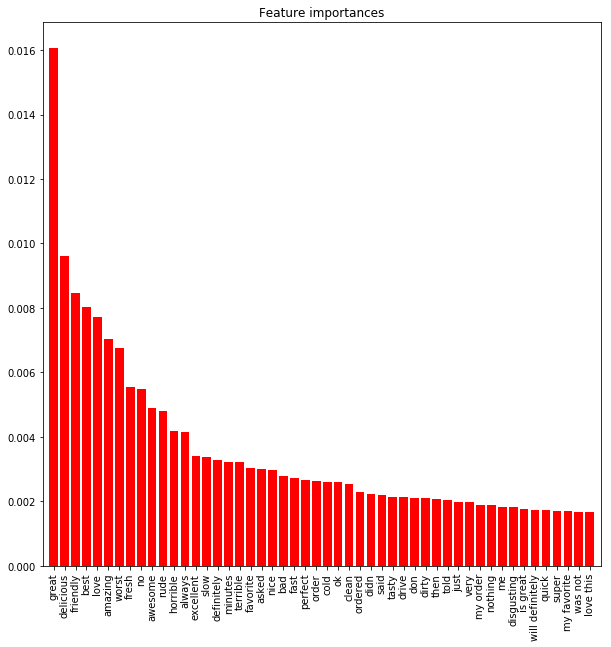

In [17]:
ord_ind = plot_featimportances(rf, Xtrain, vectorizer, figname = 'FeatImp_tfidf.png')

In [18]:
outfile = open('feat_imp_order.pkl', 'wb')
pickle.dump(ord_ind, outfile)
outfile.close()